In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import os
cwd = os.getcwd()

from geopy.geocoders import Nominatim
import requests
import zipfile
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
import plotly.express as px
from shapely.geometry import Point
from IPython.display import Image

import nbconvert
from nbconvert import HTMLExporter
import nbformat

# Introduction: 

####  I would like to prove that there is an observable correlation between industrial production/presence in a given region and cancer/chronic illness rates. There was a Tulane study published which implicated industrial production in the "Industrial Coridor" with elevated cancer risk.

# Goals: 

#### I would like to first investigate and uphold these claims, and then gain insight into the emprical relation between the two phenomena, to eventually develop a model capable of predicting health consequences of industrial sites.

In [62]:
try:
    import google.colab
    from google.colab import drive

    drive.mount('/content/drive')
    drive_path = '/content/drive/My Drive/Data Science Final Project'

    os.chdir(drive_path)
    cwd = os.getcwd()
    colab = True

    print("Current Working Directory:", cwd)


except ImportError:
    cwd = os.getcwd()
    colab = False

    print("Current *Local* Working Directory:", cwd)

Current *Local* Working Directory: /Users/arturoaltamirano808/Desktop/arturoAltamirano


# How Prevalent is Cancer? 

### Let's see how cancer has changed over the years and how it may be affecting us. Data acquired from the below source: 

#### https://www.kaggle.com/datasets/antimoni/cancer-deaths-by-country-and-type-1990-2016

In [63]:
df = pd.read_csv(os.path.join(cwd, 'data', 'cancer_deaths.csv'))

#isolate to only the US and order chronologically, may analyze other countries later on
usa_df = df[df['Code'] == 'USA'].copy()
usa_df.columns = usa_df.columns.str.strip()
usa_df.sort_values(by='Year', ascending=True, inplace=True)

#print(tabulate(usa_df, headers='keys', tablefmt='github', showindex=False))

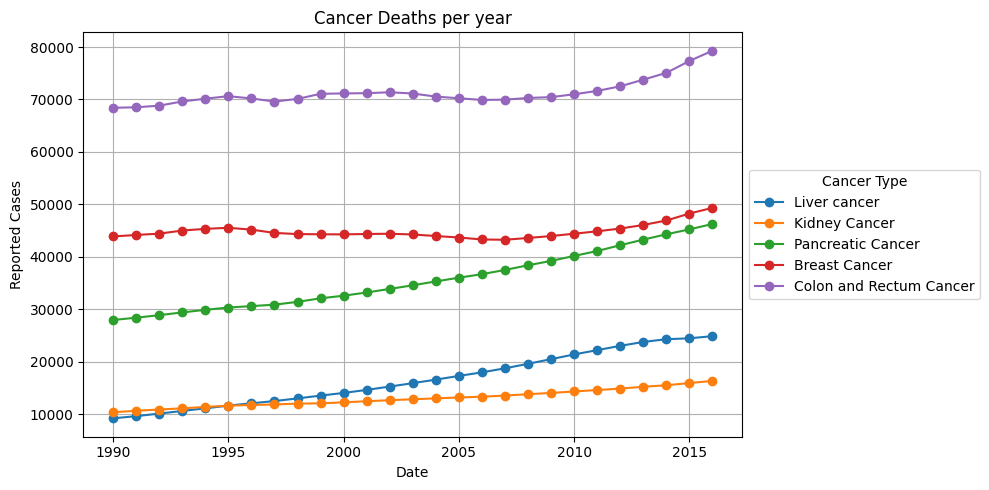

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(usa_df['Year'], usa_df['Liver cancer'], marker='o', label='Liver cancer')
plt.plot(usa_df['Year'], usa_df['Kidney cancer'], marker='o', label = 'Kidney Cancer')
plt.plot(usa_df['Year'], usa_df['Pancreatic cancer'], marker='o', label = 'Pancreatic Cancer')
plt.plot(usa_df['Year'], usa_df['Breast cancer'], marker='o', label = 'Breast Cancer')
plt.plot(usa_df['Year'], usa_df['Colon and rectum cancer'], marker='o', label = 'Colon and Rectum Cancer')

plt.title('Cancer Deaths per year')
plt.xlabel('Date')
plt.ylabel('Reported Cases')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Cancer Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# Cancer Rates Are Rising: But Why?

### It is obvious that cancer is growing as a threat to public health. Can we identify a potential cause of this increase? 

### As stated previously, industrial effects are often blamed, including this Tulane Publication: 

#### https://law.tulane.edu/news/tulane-study-louisianas-severe-air-pollution-linked-dozens-cancer-cases-each-year. 

In [65]:
df = pd.read_csv(os.path.join(cwd, 'data', 'water_pollution.csv'))

#df = df[0:5000].copy()

#going to use these to track positional data
geolocator = Nominatim(user_agent="geoapi")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

#utility function to extract US data 
def get_us_country(lat, lon):
    try:
        location = geocode((lat, lon), language='en')
        if location is not None and 'address' in location.raw:
            address = location.raw['address']
            if address.get('country') == 'United States':
                #get state
                return address.get('state') or 'Unknown state'
        return None

    except:
        return None


#df['State'] = df.apply(
#    lambda row: get_us_country(row['Geographical Location (Latitude)'], row['Geographical Location (Longitude)']),
#    axis=1)

#df_clean = df.dropna(subset=['State'])
#df_clean.to_pickle('us_locations.pkl')

#print(tabulate(df_clean, headers='keys', tablefmt='github', showindex=False))

# Can we Uphold these Claims?

### Below are samples of Nitrogen and Phosphorus acquired from this data source: 

#### https://www.kaggle.com/datasets/snmahsa/water-quality-and-sewage-system-dataset

### The presence of Nitrogen and Phosphorus are often indicators of pollution that has contaminated the soil/water supply of a location.

In [66]:
df_us = pd.read_pickle('data/us_locations.pkl')

#print(tabulate(df_us, headers='keys', tablefmt='github', showindex=False))

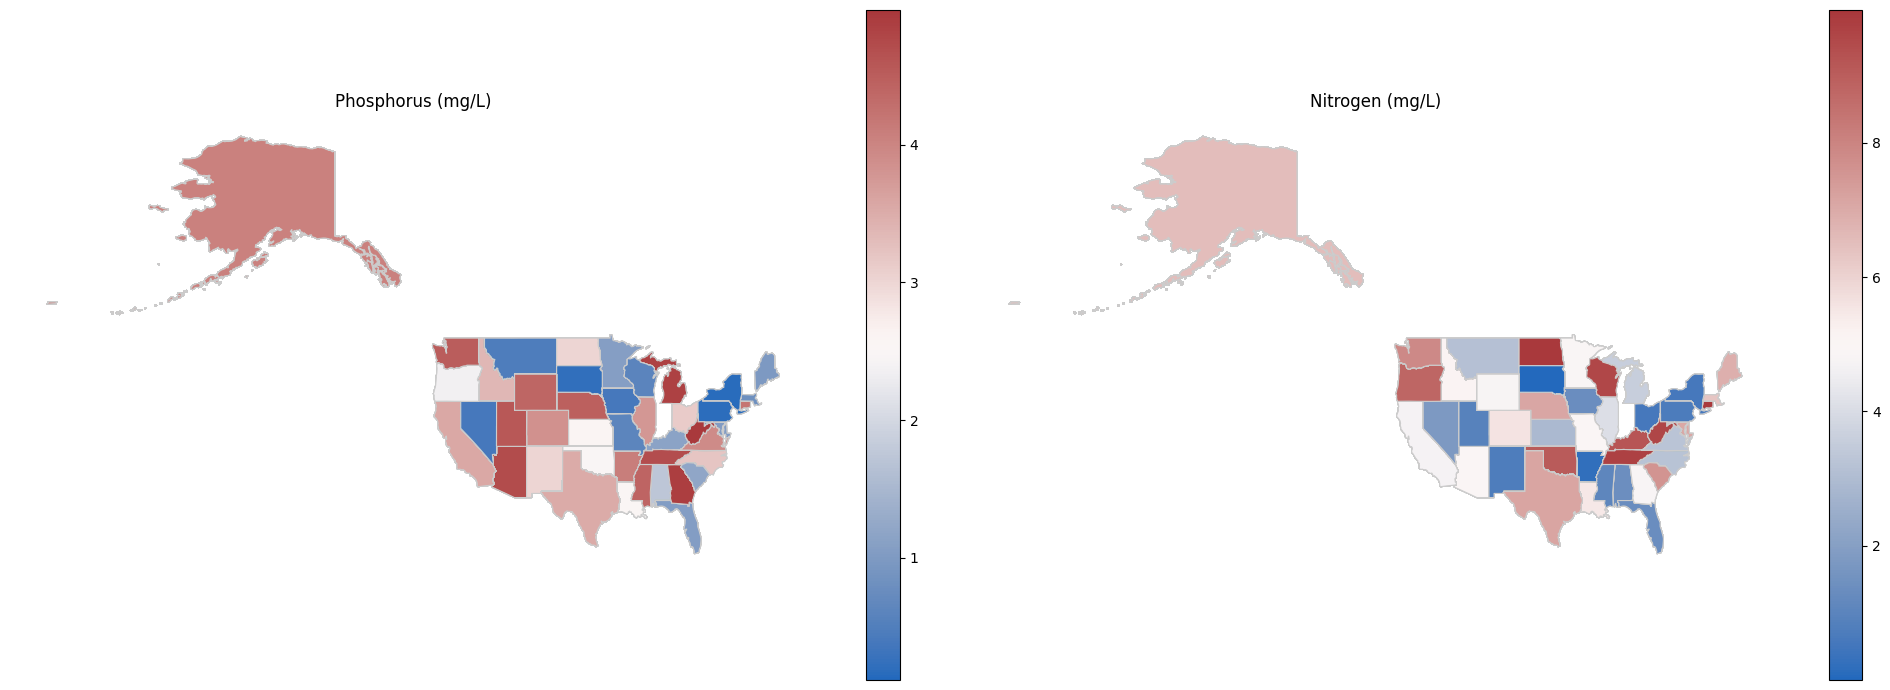

In [67]:
us_states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')
merged_measures = us_states.merge(df_us, left_on='name', right_on='State')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

merged_measures.plot(
    column='Phosphorus (mg/L)', cmap='vlag', linewidth=0.8,
    ax=ax1, edgecolor='0.8', legend=True
)

ax1.set_title('Phosphorus (mg/L)')
ax1.axis('off')

merged_measures.plot(
    column='Nitrogen (mg/L)', cmap='vlag', linewidth=0.8,
    ax=ax2, edgecolor='0.8', legend=True
)

ax2.set_title('Nitrogen (mg/L)')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Polution and Cancer, is there a Corellation? 

### Let's look and see how the two metrics stack up on a state-by-state level. We will be comparing the measured polution to the reported incidence rates of cancer provided by the following data source. 

#### https://www.kaggle.com/datasets/varunraskar/cancer-regression?select=cancer_reg.csv

In [68]:
df = pd.read_csv(os.path.join(cwd, 'data', 'cancer_reg.csv'))

#drop the city designation and just keep the state
df['State'] = df['geography'].str.split(',').str[-1].str.strip()

#group by state and average - will use this later
state_avg = df.groupby('State').mean(numeric_only=True).reset_index()

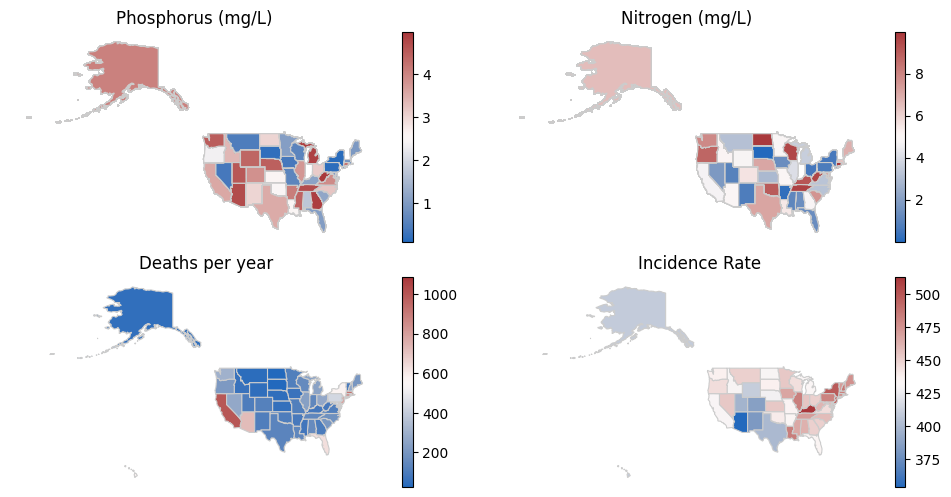

In [69]:
#load a graphic of the US using geoJSON
us_states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

#merge in the state averages to the map
merged = us_states.merge(state_avg, left_on='name', right_on='State')

#set up 2x2 grid for future scalability (only using 2 now)
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.flatten()

merged_measures.plot(
    column='Phosphorus (mg/L)', cmap='vlag', linewidth=0.8,
    ax=axes[0], edgecolor='0.8', legend=True
)
axes[0].set_title('Phosphorus (mg/L)')
axes[0].axis('off')

merged_measures.plot(
    column='Nitrogen (mg/L)', cmap='vlag', linewidth=0.8,
    ax=axes[1], edgecolor='0.8', legend=True
)
axes[1].set_title('Nitrogen (mg/L)')
axes[1].axis('off')

merged.plot(column='avgdeathsperyear', cmap='vlag', linewidth=0.8,
            ax=axes[2], edgecolor='0.8', legend=True)
axes[2].set_title('Deaths per year')
axes[2].axis('off')

merged.plot(column='incidencerate', cmap='vlag', linewidth=0.8,
            ax=axes[3], edgecolor='0.8', legend=True)
axes[3].set_title('Incidence Rate')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Measured Pollution and Cancer:

### There seems to be a correlation between sampled nitrogen quantities and incidence rates of cancer, this needs further examination.

In [70]:
def get_county(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), language='en', exactly_one=True, timeout=10)
        if location and 'address' in location.raw:
            address = location.raw['address']
            return address.get('county') or address.get('parish') or address.get('state_district') or address.get('region')

        return None

    except Exception as e:
        print(f"Error at ({lat},{lon}): {e}")
        return None

In [71]:
def nitrogen_samples(df, fips_code, state_name):
    
    #get only data for our desired state
    df_state_nitrogen = df[df['State'].str.contains(state_name, case=False, na=False)].copy()

    #acquire county from the lat lon coordinates - use fancy lambda for list iteration and string indexing
    df_state_nitrogen.loc[:, 'County'] = df_state_nitrogen.apply(
    lambda row: get_county(row['Geographical Location (Latitude)'], row['Geographical Location (Longitude)']),
    axis=1)

    #group all county entries together to get totals by county
    countyTotals = df_state_nitrogen.groupby('County').agg({
    'Nitrogen (mg/L)': 'mean',
    'Phosphorus (mg/L)': 'mean'
    }).reset_index()

    #could do some kind of evaluation here - but rather explicitly search for both in case it uses a parish system
    countyTotals['County'] = countyTotals['County'].str.split('Parish').str[0].str.strip()
    countyTotals['County'] = countyTotals['County'].str.split('County').str[0].str.strip()

    #avoid capitilization issues between strings 
    countyTotals['County'] = countyTotals['County'].str.title()

    #print(countyTotals)

    if colab == True:
      zip_path = os.path.join(cwd, 'cb_2018_us_county_500k.zip')

      with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("county_shapefiles")

      counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')

    else:
      with zipfile.ZipFile(os.path.join(cwd, "data/cb_2018_us_county_500k.zip"), "r") as zip_ref:
          zip_ref.extractall("county_shapefiles")

          counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')

    #merge these together to plau nice with other data
    state_counties = counties[counties['STATEFP'] == fips_code]
    merged = state_counties.merge(countyTotals, left_on='NAME', right_on='County', how='left')

    return merged


In [72]:
def state_countyMetrics(state_name, fips_code):

    #get my data from the zip and from the pickle data 
    df_cancer_rates = pd.read_csv(os.path.join(cwd, 'data', 'county_zip_reg.csv'), encoding='latin1')
    df_nitrogen_samples = pd.read_pickle('data/us_locations.pkl')

    #get my polution data
    state_nitrogen = nitrogen_samples(df_nitrogen_samples, fips_code, state_name)

    #filter for only those whose county field (County, State) contains state name
    filtered_df = df_cancer_rates[df_cancer_rates['County'].str.contains(state_name, case=False, na=False)]

    countyTotals = filtered_df.groupby('County').agg({
        'incidenceRate': 'mean',
        'deathRate': 'mean',
        'avgDeathsPerYear': 'mean',
    }).reset_index()

    #drop the parish/county designation (Acadiana Parish -> Acadiana, Harris County -> Harris) to match other formats
    countyTotals['County'] = countyTotals['County'].str.split('Parish').str[0].str.strip()
    countyTotals['County'] = countyTotals['County'].str.split('County').str[0].str.strip()

    #prevent capitilization issues by forcing to capital
    countyTotals['County'] = countyTotals['County'].str.title()

    if colab == True:
      zip_path = os.path.join(cwd, 'cb_2018_us_county_500k.zip')

      with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("county_shapefiles")

      counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')

    else:
      with zipfile.ZipFile(os.path.join(cwd, "data/cb_2018_us_county_500k.zip"), "r") as zip_ref:
        zip_ref.extractall("county_shapefiles")

      counties = gpd.read_file(os.path.join(cwd, 'county_shapefiles','cb_2018_us_county_500k.shp'), encoding='latin1')

    #fips code for counties data from json
    la_counties = counties[counties['STATEFP'] == fips_code]

    #merge the nitrogen samples dataset and cancer rates dataset on the county column
    merged = la_counties.merge(countyTotals, left_on='NAME', right_on='County')

    merged['Nitrogen (mg/L)'] = state_nitrogen['Nitrogen (mg/L)']
    merged['Phosphorus (mg/L)'] = state_nitrogen['Phosphorus (mg/L)']
    
    return merged

In [73]:
def nitrogen_plotter(merged):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    merged.plot(column='Nitrogen (mg/L)', cmap='vlag', linewidth=0.8, ax=ax1,
            edgecolor='0.8', legend=True,
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "black",
                "hatch": "///",
                "label": "No data"
            })
    #points_gdf.plot(ax=ax1, color='purple', markersize=150)

    ax1.set_title("Nitrogen by County (m/g L)", fontsize=16)

    ax1.set_axis_off()

    merged.plot(column='Phosphorus (mg/L)', cmap='vlag', linewidth=0.8, ax=ax2,
            edgecolor='0.8', legend=True,
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "black",
                "hatch": "///",
                "label": "No data"
            })

    #points_gdf.plot(ax=ax2, color='black', markersize=50)

    ax2.set_title('Phosphorus by County')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [74]:
def incidence_plotter(merged, name, points_gdf):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    merged.plot(column='incidenceRate', cmap='vlag', linewidth=0.8,
            ax=ax1, edgecolor='0.8', legend=True, aspect=1)

    ax1.set_title(f"Incidence Rate by County in {name}", fontsize=16)
    ax1.set_axis_off()

    merged.plot(column='deathRate', cmap='vlag', linewidth=0.8,
            ax=ax2, edgecolor='0.8', legend=True, aspect=1)

    ax2.set_title(f"Death Rate by County in {name}", fontsize=16)
    ax2.set_axis_off()

    try: 
        points_gdf.plot(ax=ax1, color='purple', markersize=100)
        points_gdf.plot(ax=ax2, color='purple', markersize=100)

    except:
        return plt

    return plt

# Louisiana Metrics 

### What does the situation in Louisiana look like? Can we gather a valuable set of insights about polution and cancer rates?

### We may need additional data surrounding the environmental state. Currently only 16 samples for 4 parishes.

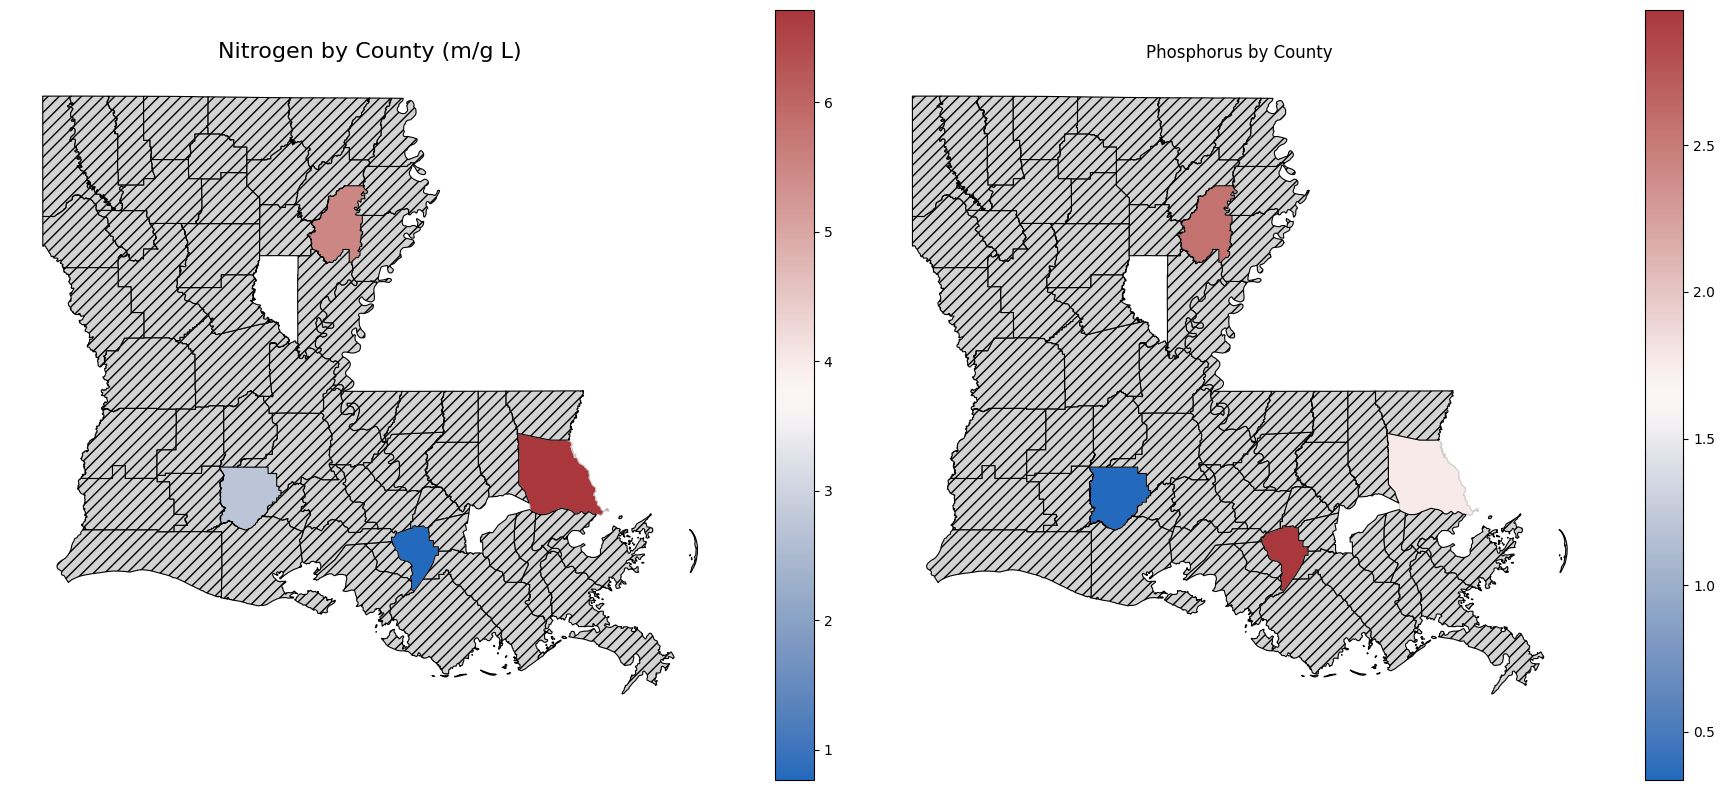

In [75]:
merged_Louisiana = state_countyMetrics('Louisiana','22')

nitrogen_plotter(merged_Louisiana)

# Louisiana Cancer Metrics

### What are the cancer rates within Louisiana, is there a noticeable disparity?

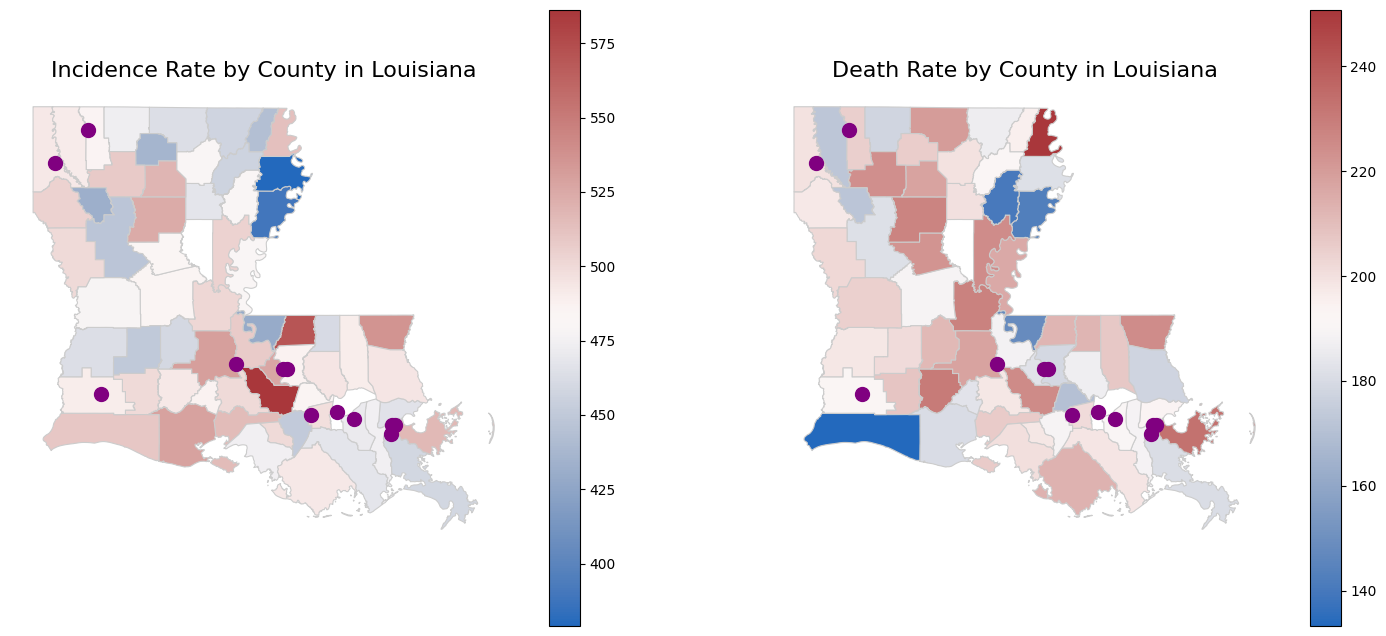

In [76]:
#points of industrial facilities - https://www.industryselect.com/blog/top-10-manufacturing-companies-in-texas
#points of petrochemical refineries - https://www.arnolditkin.com/blog/plant-accidents/comprehensive-list-of-refineries-in-texas/
points_df = pd.DataFrame({
    'Latitude': [30.483988, 29.846726, 29.938748, 30.031041, 32.797383, 30.065276, 30.526713, 30.240865, 29.933837,  29.995503, 30.476733, 32.470366],

    'Longitude': [-91.169601, -89.991966, -89.970822, -90.897768, -93.415004, -90.593545, -91.746182, -93.272194, -89.944371, -90.409877, -91.210874, -93.789677],

    'Label': ['Baton Rouge Refinery', 'Alliance Refinery', 'Chalmette Refinery', 'Convent Refinery', 'Cotton Valley Refinery',
              'Garyville Refinery','Delek Refinery', 'Phillips 66 Lake Charles', 'Meraux Valero', 'Shell Norco', 'Placid Refinery Port Allen', 'Calumet Shreveport']})

#convert lat/lon to Point geometry using shapely.point
geometry = [Point(xy) for xy in zip(points_df['Longitude'], points_df['Latitude'])]
points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs='EPSG:4326') # going based off documentation here, don't know what crs is

#apparently you need to 'reproject' these
points_gdf = points_gdf.to_crs(merged.crs)

plot = incidence_plotter(merged_Louisiana, 'Louisiana', points_gdf)

plot.show()

# Noticeable concentration

### It seems as though the conclusions drawn by the Tulane study are quantifiable with actual data. Notice the concentration of red regions near the Missisipi River in central Louisiana.

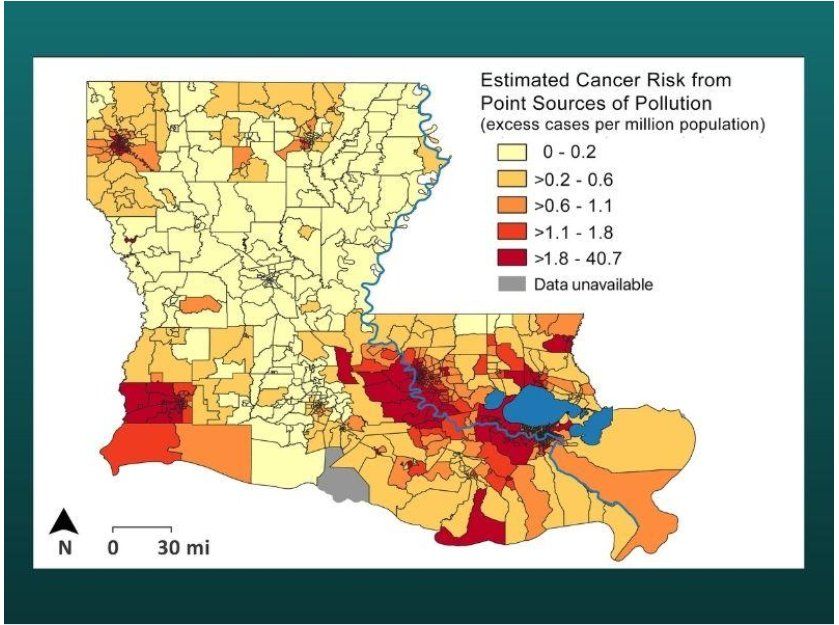

In [77]:
Image(os.path.join(cwd, 'tulaneStudy.png'))

# What about Regional Metrics?

### Can we gain insight into the disparities between states? Or the general south?

In [78]:
#points of industrial facilities - https://www.industryselect.com/blog/top-10-manufacturing-companies-in-texas
#points of petrochemical refineries - https://www.arnolditkin.com/blog/plant-accidents/comprehensive-list-of-refineries-in-texas/
points_df = pd.DataFrame({
    'Latitude': [30.483988, 29.846726, 29.938748, 30.031041, 32.797383, 30.065276, 30.526713, 30.240865, 29.933837,  29.995503, 30.476733, 32.470366,
                 
                 30.228790, 32.770222, 30.400474, 29.710871, 30.064680, 32.250530, 35.658669, 29.763359
                 ],

    'Longitude': [-91.169601, -89.991966, -89.970822, -90.897768, -93.415004, -90.593545, -91.746182, -93.272194, -89.944371, -90.409877, -91.210874, -93.789677,
                  
                  -97.619720, -97.447731, -97.661238, -95.117630, -94.075760, -101.462578, -101.406662, -95.101273

                  ],

    'Label': ['Baton Rouge Refinery', 'Alliance Refinery', 'Chalmette Refinery', 'Convent Refinery', 'Cotton Valley Refinery',
              'Garyville Refinery','Delek Refinery', 'Phillips 66 Lake Charles', 'Meraux Valero', 'Shell Norco', 'Placid Refinery Port Allen', 'Calumet Shreveport',

               #manufacturing plants and refineries in texas
              'Tesla Austin Plant', 'Lockheed Martin Plant', 'Dell Manufacturing Facility', 'Pemex-Shell Petrochemical Plant',
              'Beaumont Exxon Mobil Refinery', 'Delek Big Spring Refinery', 'Phillips 66 Borger Plant', 'Channelview LyondellBassel Petroleum Products Refinery',

              ]})

#convert lat/lon to Point geometry using shapely.point
geometry = [Point(xy) for xy in zip(points_df['Longitude'], points_df['Latitude'])]
points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs='EPSG:4326') # going based off documentation here, don't know what crs is

#apparently you need to 'reproject' these
points_gdf = points_gdf.to_crs(merged.crs)

merged_Arizona = state_countyMetrics('Arizona', '04')
merged_Arkansas = state_countyMetrics('Arkansas', '05')
merged_NewMexico = state_countyMetrics('New Mexico', '35')
merged_Mississippi = state_countyMetrics('Mississippi', '28')
merged_Oklahoma = state_countyMetrics('Oklahoma','40')
merged_Texas = state_countyMetrics('Texas','48')

merged_Alabama = state_countyMetrics('Alabama', '01')
merged_Georgia = state_countyMetrics('Georgia', '13')
merged_Florida = state_countyMetrics('Florida', '12')

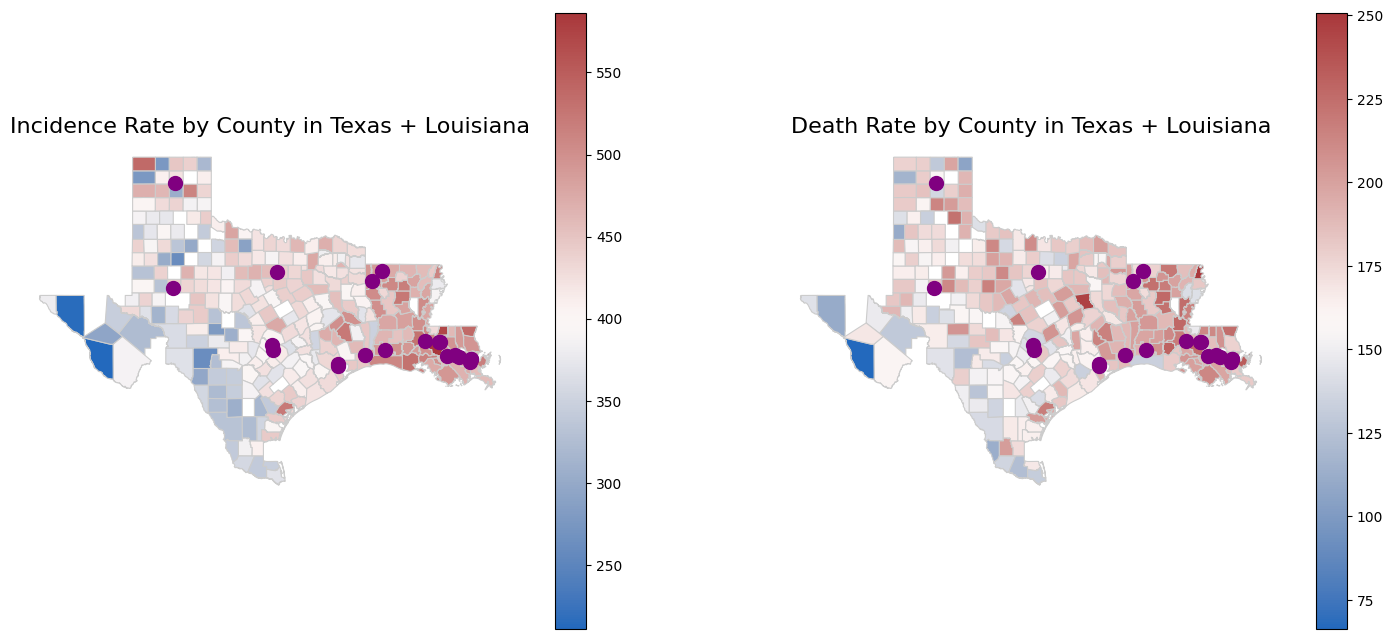

In [79]:
merged_tx_la = pd.concat([merged_Louisiana, merged_Texas])

plot = incidence_plotter(merged_tx_la, 'Texas + Louisiana', points_gdf)

# Potential for Future Evaluation:

### Going forward, I would like to find more reliable/insightful data to support the pollution levels within different counties. The current dataset is not robust enough.

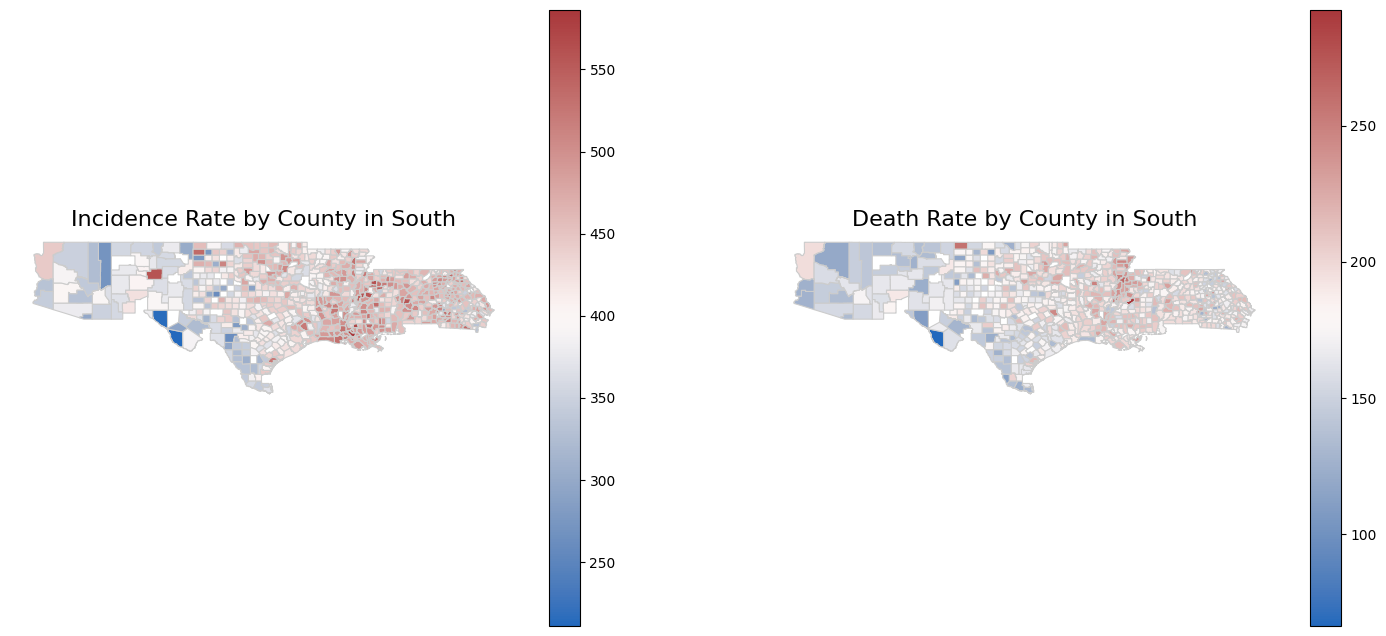

In [80]:
points_df = pd.DataFrame({
    'Latitude': [
                 ],

    'Longitude': [
                  ],

    'Label': [
              ]})

#convert lat/lon to Point geometry using shapely.point
geometry = [Point(xy) for xy in zip(points_df['Longitude'], points_df['Latitude'])]
points_gdf = gpd.GeoDataFrame(points_df, geometry=geometry, crs='EPSG:4326') # going based off documentation here, don't know what crs is

#apparently you need to 'reproject' these
points_gdf = points_gdf.to_crs(merged.crs)

merged_south = pd.concat([merged_Louisiana, merged_Texas, merged_NewMexico, merged_Arizona, merged_Oklahoma,
                          merged_Arkansas, merged_Mississippi, merged_Alabama, merged_Georgia])

plot = incidence_plotter(merged_south, 'South', points_gdf)

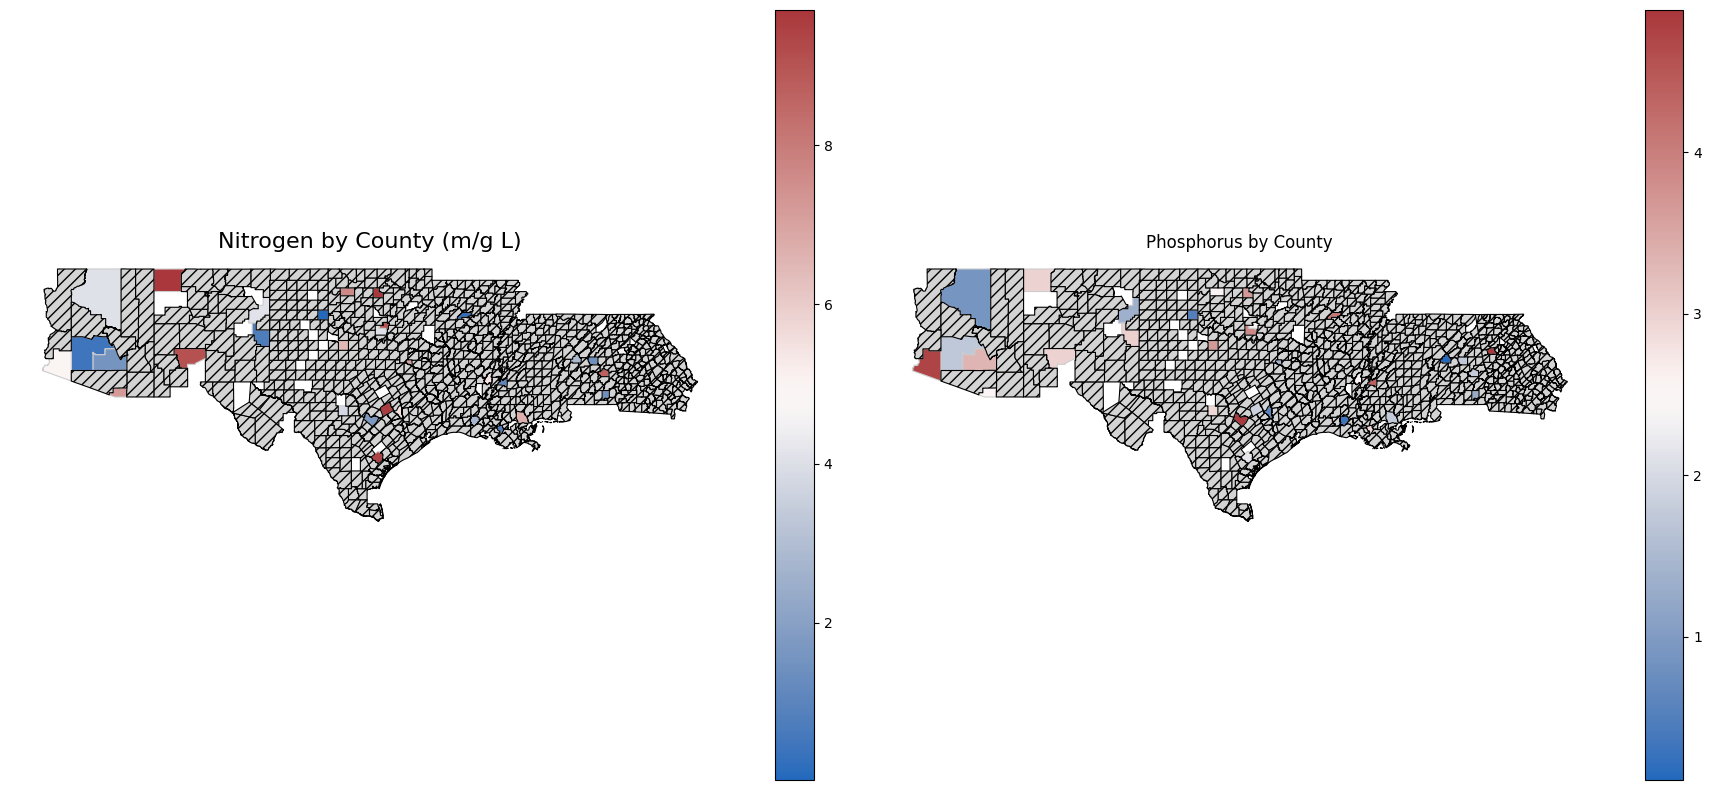

In [81]:
nitrogen_plotter(merged_south)

In [ ]:
notebook_filename = "polutionLouisiana.ipynb"
with open(notebook_filename) as f:
    notebook = nbformat.read(f, as_version=4)

html_exporter = HTMLExporter()
html_exporter.theme = 'dark'

(body, resources) = html_exporter.from_notebook_node(notebook)

output_filename = "polutionLouisiana.html"
with open(output_filename, "w", encoding="utf-8") as f:
    f.write(body)